<a href="https://colab.research.google.com/github/ehsan-lari/flwr101/blob/main/flwr_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning flwr --> Fashion-MNIST Dataset
---

## 1. Preparation

In [ ]:
%pip install -q flwr[simulation] -q flwr-datasets[vision]

In [2]:
import flwr

In [3]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner

In [4]:
fds = FederatedDataset(
    dataset="zalando-datasets/fashion_mnist",
    partitioners={
        "train": DirichletPartitioner(
            num_partitions=10,
            partition_by="label",
            alpha=0.4,
            seed=42,
            min_partition_size=0,
        ),
    },
)

In [ ]:
NO_PARTITION = 1

partition = fds.load_partition(NO_PARTITION, "train")

print(f"Partition {NO_PARTITION} size: {partition.shape}")

In [6]:
centralized_dataset = fds.load_split("test")

In [7]:
partitioner = fds.partitioners["train"]

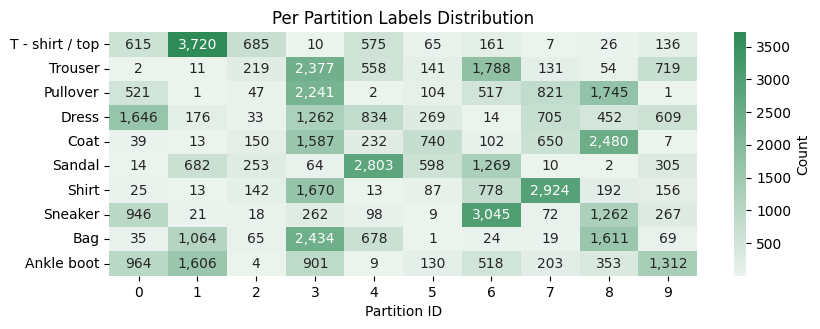

In [8]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="heatmap",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
    plot_kwargs={"annot": True},
)

In [37]:
# torch.randint(partition.shape[0], (1,10))

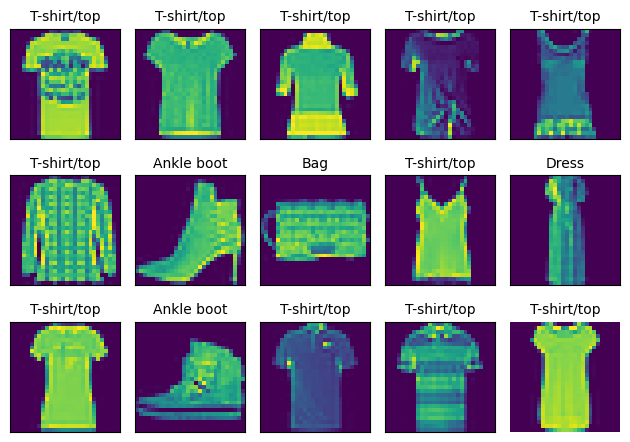

In [40]:
import matplotlib.pyplot as plt
import torch

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

for i in range(15):

  NO_IMG = torch.randint(0, partition.shape[0], (1,)).item()

  image = partition[NO_IMG]["image"]
  label = partition[NO_IMG]["label"]
  plt.subplot(3, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(class_names[label]).set_fontsize(10)
  plt.imshow(image)
  plt.tight_layout()
plt.axis("off")
plt.show()

In [38]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [39]:
transforms = ToTensor()

In [41]:
BATCH_SIZE = 32

def apply_transforms(batch):
    batch["image"] = [transforms(img) for img in batch["image"]]
    return batch

partition_torch = partition.with_transform(apply_transforms)
dataloader = DataLoader(partition_torch, batch_size=BATCH_SIZE)

In [42]:
train_data_loader = DataLoader(dataset=partition_torch,
                               batch_size=1,
                               shuffle=True)
test_data_loader = DataLoader(dataset=centralized_dataset,
                              batch_size=1,
                              shuffle=False)

In [43]:
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
partition_train = partition_train_test["train"]
partition_test = partition_train_test["test"]

In [44]:
import torch
from torch import nn
from torch.nn import Sequential, Conv2d, ReLU, MaxPool2d, Flatten, Linear

In [45]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
      # x = self.conv_block_1(x)
      # x = self.conv_block_2(x)
      # x = self.classifier(x)
      # return x
      return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [46]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [47]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():

      for batch, (X, y) in enumerate(dataloader):
        y_test = model(X)
        loss = loss_fn(y_test, y)
        test_loss += loss.item()

        y_test_class = torch.argmax(torch.softmax(y_test, dim=1), dim=1)
        test_acc += (y_test_class == y).sum().item()/len(y_test)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [48]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs: int = 5):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_data_loader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_data_loader,
                                    loss_fn=loss_fn)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
torch.manual_seed(42)

NUM_EPOCHS = 10

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                         train_data_loader=train_data_loader,
                         test_data_loader=test_data_loader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")